In [1]:
import sys
sys.path.append("/Users/ueki/.pyenv/versions/3.7.3/lib/python3.7/site-packages")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from math import ceil

# Binary classification

## create data

In [3]:
# prepare dataset
np.random.seed(777)

In [4]:
# dataset 4
N = 200
D=4
x = 3 * (np.random.rand(N, 4) - 0.5)
y = (2 * x[:, 0] - 1 * x[:,1] + 0.5 + 0.5 * np.random.randn(N)) > 0
y = 2 * y -1
W_init= np.ones(D)

In [5]:
N_iter =100

In [6]:
y.shape

(200,)

In [7]:
x.shape

(200, 4)

In [8]:
W_init.shape

(4,)

## batch steepest gradient method

### functions

In [9]:
def calc_loss(x,w,y):
    xy = x*y.reshape(-1,1)
    posterior = 1/(1+np.exp(np.dot(-xy,ww))) # (N,1)
    loss = np.average(np.log(1+np.exp(-y*np.dot(ww,x.T))),axis=0) #(scalar)
    return loss

In [10]:
def calc_grad(x,w,y):
    xy = x*y.reshape(-1,1)
    posterior = 1/(1+np.exp(np.dot(-xy,ww))) # (N,1)
    grad = np.average(-xy*(1-posterior.reshape(-1,1)),axis=0) #(D,1)
    return grad

In [11]:
def calc_hess(x,w,y):
    xy = x*y.reshape(-1,1)
    posterior = 1/(1+np.exp(np.dot(-xy,ww))) # (N,1)
    hess = np.average(xy**2*(posterior*(1-posterior)).reshape(-1,1),axis=0) #(D,1)
    return hess

### steepset gradient descent

In [12]:
#epoch
num_iter = N_iter
#重みの初期値
lam=0.01

In [13]:
grad_loss_history = []
grad_ww_history = []
lip = np.max(x**2)
alpha_base =1/ lip

In [14]:
ww = W_init
for t in range(1,num_iter+1):
    grad = calc_grad(x,ww,y) + 2*lam*ww
    loss = calc_loss(x,ww,y)+lam*(np.dot(ww.T,ww)+1) #(scalar)
    #history
    grad_ww_history.append(ww)
    grad_loss_history.append(loss)
    #update
    ww = ww - alpha_base*grad

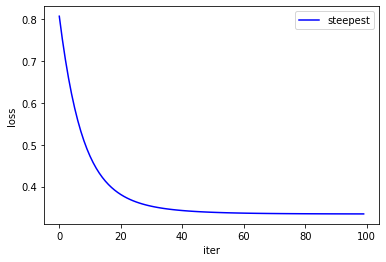

In [15]:
plt.plot(grad_loss_history, 'b', markersize=0.5, label='steepest')
plt.legend()
plt.xlabel('iter')
plt.ylabel('loss')
plt.show()

### newton based method

In [16]:
from numpy.linalg import inv

In [17]:
#epoch
num_iter = N_iter
#learning history
newton_loss_history = []
newton_ww_history = []

In [18]:
ww = W_init
for t in range(1,num_iter+1):
    grad = calc_grad(x,ww,y) + 2*lam*ww
    loss = calc_loss(x,ww,y) + lam*(np.dot(ww.T,ww)+1)
    hess = calc_hess(x,ww,y)#+2*lam
    assert hess.shape == ww.shape
    #history
    newton_ww_history.append(ww)
    newton_loss_history.append(loss)
    #update
    ww = ww - grad/hess/np.sqrt(t+10)

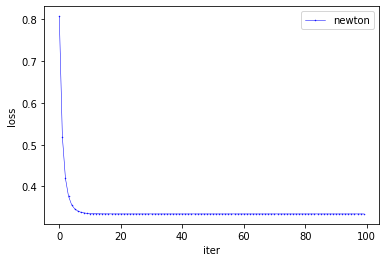

In [19]:
plt.plot( newton_loss_history, 'bo-', linewidth=0.5, markersize=0.5, label='newton')
plt.legend()
plt.xlabel('iter')
plt.ylabel('loss')
plt.show()

## compare performance

In [20]:
optimal_w = min(min(grad_loss_history),min(newton_loss_history))

Text(0, 0.5, 'Loss diff from the gold weight')

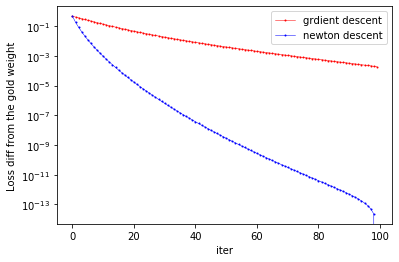

In [21]:
plt.plot(np.abs(grad_loss_history-optimal_w),'ro-',linewidth=0.5,markersize=1,label="grdient descent")
plt.plot(np.abs(newton_loss_history-optimal_w),'bo-',linewidth=0.5,markersize=1,label="newton descent")
plt.legend()
plt.yscale("log")
plt.xlabel("iter")
plt.ylabel("Loss diff from the gold weight")

# adaptation to Multi class classification

## create Data (Toy dataset V)

In [22]:
# dataset 5
N = 200
D=3
N_class=4
x =3* (np.random.rand(N,D) - 0.5)
W_init = np.random.rand(N_class,D)
y = np.argmax(np.dot(np.hstack([x[:,:N_class-2],np.ones((N,1))]),W_init.T) + 0.5*np.random.randn(N,N_class),axis=1)

In [23]:
x.shape

(200, 3)

In [24]:
x = 3* (np.random.rand(N,D) - 0.5)
x.shape

(200, 3)

In [25]:
def to_categorical(y):
    """
    convert input vector y to one_hot_vector
    """
    size = np.max(y)
    y_one_hot = np.identity(size+1)[y]
    return y_one_hot

In [26]:
y_one_hot = to_categorical(y)

In [27]:
lam = 0.01

## classification

### functions

In [28]:
def softmax(w):
    """
    paremeter
    ----------------
        w:  parameter
    ----------------
    return
    -------------
        soft_max : vec (N,D)
    """
    assert w.shape == (N,N_class)
    C = np.max(w)
    exp_y= np.exp(w-C)
    exp_sum = np.sum(np.exp(w-C),axis=0) #　ここは良さそう
    ret = exp_y.T / exp_sum.reshape(-1,1)
    return ret.T

In [29]:
def calc_loss(x,w,ans):
    """
    ans: one_hot vector
    return
    ----------
    ret: scalar
    """
    v1 = np.sum((np.dot(y_one_hot,w.T)*x),axis=1)
    v2 =np.max(np.dot(x,ww.T),axis=1)
    loss = np.average(-v1+v2)
    return loss
    

In [30]:
def calc_grad1(x,w,y_one_hot):
    """
    ret: grad shapes like w
    """
    s  = softmax(np.dot(ww,x.T))
    ret = np.zeros_like(w)
    #(N,D)と(N,C)から、(N,np.dot(D,C))を作る
    #それをNについてaverage
    ret =np.average(np.einsum("mij,mjk-> mik",s.reshape(N,-1,1),x.reshape(N,1,-1)),axis=0)
    return ret

In [65]:
def calc_grad(x,w,y_one_hot):
    assert x.shape == (N,D)
    assert w.shape == (N_class,D)
    s = softmax(np.dot(x,w.T))
    ret = np.zeros_like(w)
    for xi,si,yi in zip(x,s,y_one_hot):
        jy = np.sum(si*yi)
        xy = xi*jy
        
        yk = yi.reshape(-1,1)
        yk = yk-si.reshape(-1,1)
        
        g = np.dot(yk,xy.reshape(1,-1))
        ret = ret+g
        assert xi.shape == (D,)
        assert jy.shape == ()
        assert yk.shape == (N_class,1)
        assert si.shape == (N_class,)
        assert g.shape == w.shape
    return ret/N
        

In [81]:
def calc_hess(x,w,y_one_hot):
    """
    ret: hessian shapes like w
    """
    assert x.shape == (N,D)
    assert w.shape == (N_class,D)
    s = softmax(np.dot(x,w.T))
    ret = np.zeros_like(w)
    for xi,si,yi in zip(x,s,y_one_hot):
        jy = np.sum(si*yi)
        xy = xi*jy
        
        yk = yi.reshape(-1,1)
        yk = yk-si.reshape(-1,1)
        
        g = np.dot(yk,xy.reshape(1,-1))
        xx = np.sum(xi**2)
        assert xx.shape==()
        g = g*xx
        ret = ret+g
        assert xi.shape == (D,)
        assert jy.shape == ()
        assert yk.shape == (N_class,1)
        assert si.shape == (N_class,)
        assert g.shape == w.shape
        assert ret.shape == w.shape
    return ret/N

In [99]:
def calc_hess(x,w,y_one_hot):
    """
    ret: hessian shapes like w
    """
    assert x.shape == (N,D)
    assert w.shape == (N_class,D)
    s = softmax(np.dot(x,w.T))
    ret = np.zeros_like(w)
    for xi,si,yi in zip(x,s,y_one_hot):
        jy = np.sum(si*yi)
        xy = xi*jy
        
        yk = yi.reshape(-1,1)
        yk = yk-si.reshape(-1,1)
        
        g = np.dot(yk,xy.reshape(1,-1))
        xx = np.sum(xi**2)
        assert xx.shape==()
        g = g*xx
        ret = ret+g
        assert xi.shape == (D,)
        assert jy.shape == ()
        assert yk.shape == (N_class,1)
        assert si.shape == (N_class,)
        assert g.shape == w.shape
        assert ret.shape == w.shape
    return ret/N

## steepest gradient descent

In [82]:
#epoch
num_iter = N_iter
#learning history
steep_loss_history = []
steep_ww_history = []
lip = np.max(x**2)
alpha = 1/lip

In [83]:
alpha

0.4458945013338183

In [84]:
ww = W_init
for t in range(1,num_iter+1):
    grad = calc_grad(x,ww,y_one_hot)+2*lam*ww
    loss = calc_loss(x,ww.T,y_one_hot) + lam*(np.sum(ww**2))
    steep_ww_history.append(ww)
    steep_loss_history.append(loss)
    #update
    ww = ww-alpha*grad

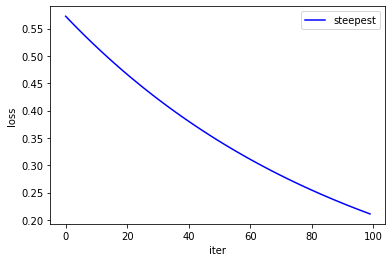

In [85]:
plt.plot(steep_loss_history, 'b', markersize=0.5, label='steepest')
plt.legend()
plt.xlabel('iter')
plt.ylabel('loss')
plt.show()

## Newton method ?

In [100]:
#epoch
num_iter = N_iter
#learning history
newton_loss_history = []
newton_ww_history = []

In [95]:
ww = W_init
for t in range(1,num_iter+1):
    grad = calc_grad(x,ww,y_one_hot)+2*lam*ww # shape(ww)
    hess = calc_hess(x,ww,y_one_hot) + 2*lam # shape(ww)
    assert hess.shape == grad.shape
    loss = calc_loss(x,ww.T,y_one_hot)+lam*(np.sum(ww**2))  # shape(scalar)
    newton_ww_history.append(ww)
    newton_loss_history.append(loss)
    #update
    ww = ww-grad/hess

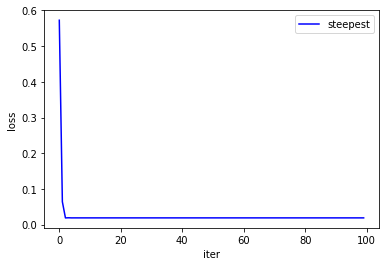

In [96]:
plt.plot(newton_loss_history, 'b', markersize=0.5, label='steepest')
plt.legend()
plt.xlabel('iter')
plt.ylabel('loss')
plt.show()

In [97]:
optimal_w = min(min(steep_loss_history),min(newton_loss_history))

Text(0, 0.5, 'Loss diff from the gold weight')

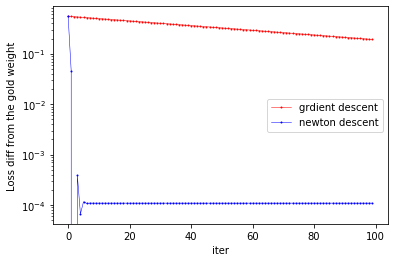

In [98]:
plt.plot(np.abs(steep_loss_history-optimal_w),'ro-',linewidth=0.5,markersize=1,label="grdient descent")
plt.plot(np.abs(newton_loss_history-optimal_w),'bo-',linewidth=0.5,markersize=1,label="newton descent")
plt.legend()
plt.yscale("log")
plt.xlabel("iter")
plt.ylabel("Loss diff from the gold weight")